# Unit 7 Assignment:  JTomines_Climate
Author: Jose Tomines<br>
Date:  2018-12-22<br>
Comments:<br>
1) Difficult to get a date string directly from querying the database for the latest date in the measurements table.  The value returned came with both brackets, parenthesis, and a comma.  Had to "MacGiver" it by using split() function to get a clean date string.
2) My summary of precipitation has a different count because I removed all NaN rows to minimize gaps in the bar graph.

In [2]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [3]:
import numpy as np
import pandas as pd

In [4]:
import datetime as dt
from datetime import datetime, timedelta

# Reflect Tables into SQLAlchemy ORM

In [5]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [6]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [7]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [8]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [9]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [10]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [11]:
# Determine columns of table measurement
Measurement.__table__.columns.keys()

['id', 'station', 'date', 'prcp', 'tobs']

In [12]:
# Determine columns of table station
Station.__table__.columns.keys()

['id', 'station', 'name', 'latitude', 'longitude', 'elevation']

# Exploratory Climate Analysis

<function matplotlib.pyplot.show(*args, **kw)>

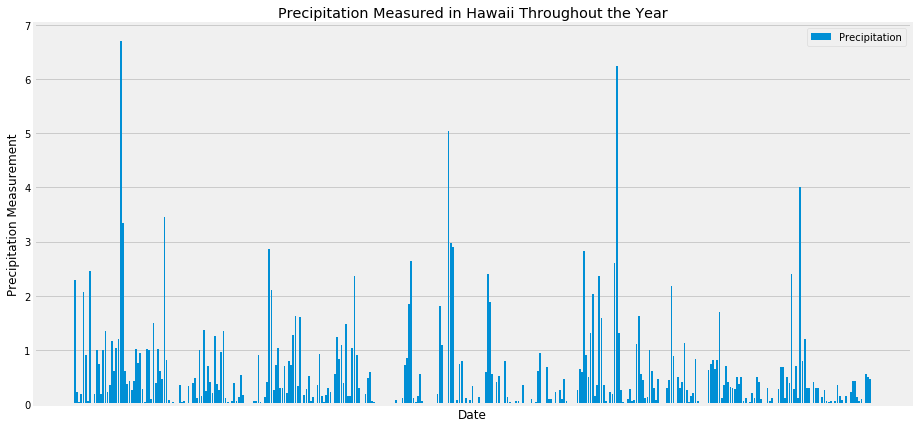

In [15]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database
latest_date_str = str(engine.execute('SELECT date FROM measurement ORDER BY date DESC LIMIT 1').fetchall()).split("'")[1]

latest_date = datetime.strptime(latest_date_str, '%Y-%m-%d')
start_date_str = f"{(latest_date.year - 1)}-{latest_date.month:02}-{latest_date.day:02}"

# Perform a query to retrieve the data and precipitation scores
# Save the query results as a Pandas DataFrame and set the index to the date column
measurement_df = pd.read_sql(session.query(Measurement.id, Measurement.date, Measurement.prcp).filter(Measurement.date > start_date_str).statement, session.bind)
measurement_df.set_index('id', inplace=True)
measurement_df = measurement_df.rename(columns = {'prcp':'precipitation'})
measurement_df = measurement_df.dropna()

# Sort the dataframe by date
measurement_df = measurement_df.sort_values('date')

# Use Pandas Plotting with Matplotlib to plot the data
plt.bar(measurement_df.date, measurement_df.precipitation, label='Precipitation')

plt.title("Precipitation Measured in Hawaii Throughout the Year")
plt.xlabel("Date")
plt.ylabel("Precipitation Measurement")
plt.xticks([])
plt.legend()
plt.gcf().set_size_inches(14, 7)

plt.show

![precipitation](Images/precipitation.png)

In [16]:
# Use Pandas to calcualte the summary statistics for the precipitation data
summary=pd.DataFrame(measurement_df.precipitation.describe())
summary

,precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


![describe](Images/describe.png)

In [17]:
# Design a query to show how many stations are available in this dataset?
numStations = session.query(Station).count()
print(f"There are {numStations} stations in this dataset")

There are 9 stations in this dataset


In [18]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
stn_activity_df = pd.read_sql(session.query(Measurement.station, func.count(Measurement.station)).group_by(Measurement.station).statement, session.bind)
stn_activity_df = stn_activity_df.rename(columns = {"count_1":"measurement count"})
stn_activity_df = stn_activity_df.sort_values('measurement count', ascending=False).reset_index(drop=True)
stn_activity_df

,station,measurement count
0,USC00519281,2772
1,USC00519397,2724
2,USC00513117,2709
3,USC00519523,2669
4,USC00516128,2612
5,USC00514830,2202
6,USC00511918,1979
7,USC00517948,1372
8,USC00518838,511


In [33]:
# Using the station id from the previous query, calculate the lowest temperature recorded,
# highest temperature recorded, and average temperature most active station?
topStation = stn_activity_df.iloc[0][0]

minTemp = float(str(session.query(func.min(Measurement.tobs)).filter(Measurement.station == topStation).all()).split("(")[1].split(",")[0])
maxTemp = float(str(session.query(func.max(Measurement.tobs)).filter(Measurement.station == topStation).all()).split("(")[1].split(",")[0])
avgTemp = float(str(session.query(func.avg(Measurement.tobs)).filter(Measurement.station == topStation).all()).split("(")[1].split(",")[0])
# Jose's Note:  Yes, I had to MacGiver to remove unneeded characters

print(f"Station:  {topStation}")
print("--------------------------------")
print(f"Miniumum Temperature: {minTemp}")
print(f"Maxiumum Temperature: {maxTemp}")
print(f" Average Temperature: {avgTemp}")


Station:  USC00519281
--------------------------------
Miniumum Temperature: 54.0
Maxiumum Temperature: 85.0
 Average Temperature: 71.66378066378067


<function matplotlib.pyplot.show(*args, **kw)>

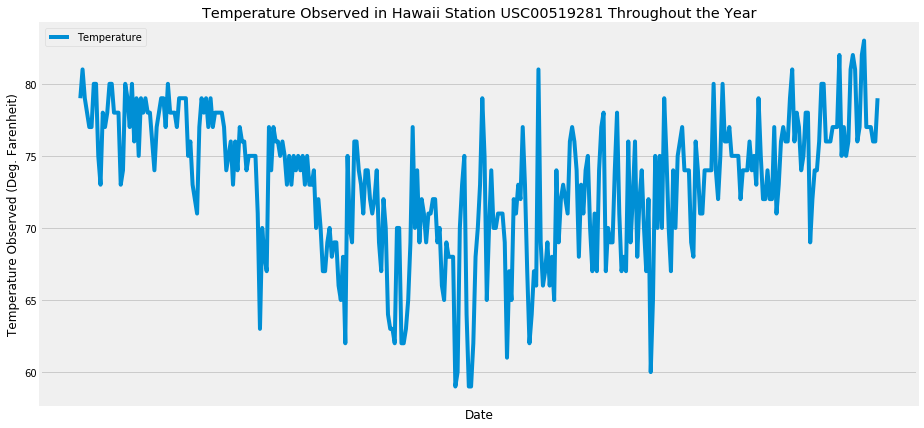

In [45]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

# Calculate the date 1 year ago from the last data point for the station with the highest number of temperature observations
filterText = f"SELECT date FROM measurement WHERE station == '{topStation}' ORDER BY date DESC LIMIT 1"
latest_date2_str = str(engine.execute(filterText).fetchall()).split("'")[1]

latest_date2 = datetime.strptime(latest_date2_str, '%Y-%m-%d')
start_date2_str = f"{(latest_date2.year - 1)}-{latest_date2.month:02}-{latest_date2.day:02}"

temperature_df = pd.read_sql(session.query(Measurement.id, Measurement.date, Measurement.tobs).filter(Measurement.date > start_date2_str).filter(Measurement.station == topStation).statement, session.bind)
temperature_df.set_index('id', inplace=True)
temperature_df = temperature_df.rename(columns = {'tobs':'temperature'})
temperature_df = temperature_df.dropna()

# Sort the dataframe by date
temperature_df = temperature_df.sort_values('date')

# Use Pandas Plotting with Matplotlib to plot the data
plt.hist(temperature_df.temperature, bins=12, label='Temperature')

plt.xlabel('Temperature Observed (Deg. Farenheit)')
plt.ylabel('Frequency')
plt.title(f"Histogram of Temperature Observed in Hawaii Station {topStation} Throughout a Full Year")
plt.legend()
plt.gcf().set_size_inches(14, 7)

plt.show()


![precipitation](Images/station-histogram.png)

In [86]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2014-05-17', '2014-05-31')) # Around the time of my 25th Wedding Anniversary

[(65.0, 74.53333333333333, 81.0)]


In [123]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
trip_start = '2017-05-14'
trip_end = '2017-05-25'

vacation_temps = calc_temps(trip_start, trip_end) # Around the time of my 28th Wedding Anniversary
tmin = vacation_temps[0][0]
tave = vacation_temps[0][1]
tmax = vacation_temps[0][2]
print("Temperatures during 28th Wedding Anniversary:")
print(f"      From '{trip_start}' To '{trip_end}'")
print("---------------------------------------------")
print(f"Minimum Temperature:  {tmin}")
print(f"Average Temperature:  {tave}")
print(f"Maximum Temperature:  {tmax}")

Temperatures during 28th Wedding Anniversary:
      From '2017-05-14' To '2017-05-25'
---------------------------------------------
Minimum Temperature:  68.0
Average Temperature:  74.76470588235294
Maximum Temperature:  87.0


<function matplotlib.pyplot.plot(*args, **kwargs)>

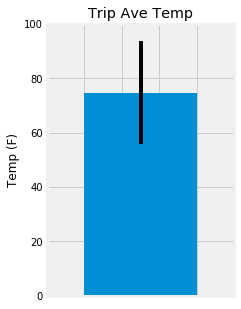

In [122]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
objects = ('Trip Avg Temp')
y = tave
x = 0.5
bar_width = 0.6
ind = np.arange(len(objects))

plt.xlim((0, 1))
plt.ylim((0,100))
plt.bar(x, y, width = bar_width, align='center', yerr=tmax-tmin)
plt.ylabel('Temp (F)')
plt.gcf().set_size_inches(3,5)
plt.title("Trip Ave Temp")
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off

plt.plot


In [128]:
# Calculate the rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
trip_rainfall_df = pd.read_sql(session.query(Measurement, Station.name, Station.latitude, Station.longitude, Station.elevation).filter(Measurement.station == Station.station).filter(Measurement.date >= trip_start).filter(Measurement.date <= trip_end).statement, session.bind)

trip_rainfall_df


,id,station,date,prcp,tobs,name,latitude,longitude,elevation
0,2627,USC00519397,2017-05-14,0.00,77.0,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0
1,2628,USC00519397,2017-05-15,0.05,78.0,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0
2,2629,USC00519397,2017-05-16,0.01,78.0,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0
3,2630,USC00519397,2017-05-17,0.00,78.0,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0
4,2631,USC00519397,2017-05-18,0.01,73.0,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0
5,2632,USC00519397,2017-05-19,0.00,76.0,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0
6,2633,USC00519397,2017-05-20,0.00,78.0,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0
7,2634,USC00519397,2017-05-21,0.00,76.0,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0
8,2635,USC00519397,2017-05-22,0.00,77.0,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0
9,2636,USC00519397,2017-05-23,0.08,87.0,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0


## Optional Challenge Assignment

In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
